## Créditos

O conteúdo deste notebook usa material do tutorial [Time series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series#single_step_models).

## Convolução 1D

Esta parte ilustra exemplos de uso da operação de convolução 1D.

### Convolução 1D em numpy

O bloco de código abaixo utiliza a função [numpy.convolve](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) para computar os elementos do vetor resultante. Veja detalhes sobre essa função em [Understanding NumPy's Convolve](https://stackoverflow.com/questions/20036663/understanding-numpys-convolve).
Nesse código, um filtro (kernel) de tamanho 3 é deslizado sobre o vetor de entrada, da esquerda para a direita. A cada posição do filtro, um valor do vetor resultante.

In [314]:
import numpy as np
input_data = [41., 5., 1., 11., 31., 17., 40.]
kernel = [.5, 1., .3]
C = np.convolve(input_data, kernel)
print(C)

[20.5 43.5 17.8  8.  26.8 42.8 46.3 45.1 12. ]


Para um entendimento mais concreto da operação de convolução, analise o bloco de código abaixo que repete a computação dos três primeiros elementos do vetor resultante.

In [315]:
kernel_array = np.array(kernel)
flipped_kernel = np.flip(kernel_array)

pos_1 = np.array([.0, .0, 41.])
print(np.dot(flipped_kernel, pos_1))

pos_2 = np.array([.0, 41., 5.])
print(np.dot(flipped_kernel, pos_2))

pos_3 = np.array([41., 5., 1.])
print(np.dot(flipped_kernel, pos_3))

20.5
43.5
17.799999999999997


O bloco de código a seguir fornece um exemplo de uso da camada Conv1d no PyTorch. Repare que o mesmo tensor obtido como resultado acima é o produzido pela camada.

In [316]:
import torch
from torch import nn

input_data = torch.tensor([[[41., 5., 1., 11., 31., 17., 40.]]])  
print('Input: %s\nshape: %s' % (input_data, input_data.shape))

conv_layer = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, padding=2) 
print()
print(conv_layer)
print()

arr = np.array([[[.3, 1., .5]]])
kernel = torch.tensor(arr, dtype = torch.float32)
conv_layer.weight.data = kernel
conv_layer.bias.data = torch.Tensor([0])

out = conv_layer(input_data)

print('Output: %s\nshape: %s' % (out, out.shape))

Input: tensor([[[41.,  5.,  1., 11., 31., 17., 40.]]])
shape: torch.Size([1, 1, 7])

Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(2,))

Output: tensor([[[20.5000, 43.5000, 17.8000,  8.0000, 26.8000, 42.8000, 46.3000,
          45.1000, 12.0000]]], grad_fn=<ConvolutionBackward0>)
shape: torch.Size([1, 1, 9])


In [317]:
import torch
from torch import nn

a = torch.randn(32, 100, 1)  
print(a.shape)
m = nn.Conv1d(100, 100, 1) 
out = m(a)
print(out.size())
print(m)

torch.Size([32, 100, 1])
torch.Size([32, 100, 1])
Conv1d(100, 100, kernel_size=(1,), stride=(1,))


### Visão intuitiva

Tão ou mais importante quanto o entendimento da transformação matemática realizada por uma convolução é ter uma visão intuitiva sobre o que faz essa operação. O propósito de cada filtro é exaltar ou atenuar certas características da série de entrada. Em [Intuitive understanding of 1D, 2D, and 3D convolutions in convolutional neural networks](https://wandb.ai/ayush-thakur/dl-question-bank/reports/Intuitive-understanding-of-1D-2D-and-3D-convolutions-in-convolutional-neural-networks---VmlldzoxOTk2MDA) o autor apresenta uma visão intuitiva do efeito de aplicação a operação de convolução.

No contexto de uma camada de convolução em um rede neural artificial, esta camada é formada por diversos filtros. A quantidade de filtros em uma camada é um dos diversos hiperparâmetros em uma camada de convolução. De todo modo, é importante entender que os pesos de cada filtro são aprendidos durante o processo de treinamento da rede neural.

# Demo: previsão de séries temporais univariadas

Créditos: o exemplo apresentado nesta seção é adaptado do tutorial [Timeseries forecasting for weather prediction](https://keras.io/examples/timeseries/timeseries_weather_forecasting/).

In [318]:
# pip install requests

In [319]:
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests, zipfile, io
import matplotlib.pyplot as plt
import os

Vamos usar nessa demonstração o conjunto de dados [Jena Climate](https://www.kaggle.com/datasets/mnassrib/jena-climate), mantido pelo [Instituto Max Planck de Biogeoquímica](https://www.bgc-jena.mpg.de/wetter/). O conjunto de dados consiste de 14 variáveis meteorológicas (como temperatura, pressão, umidade, etc). Essas observações são registradas uma vez a cada 10 minutos por uma estação meteorológica localizada na cidade de Jena, na Alemanha. A séria histórica de observações disponivel abrange os anos de 2009 até 2016. Mais detalhes sobre as variáveis componentes deste conjunto de dados podem ser encontradas [aqui](https://huggingface.co/keras-io/timeseries_forecasting_for_weather).

> Vamos construir um modelo de previsão para a variável **temperatura**.

Repare que a variável temperatura é de domínio contínuo. Portanto, estamos diante de uma tarefa de **regressão**. Para resolver essa tarefa de previsão, vamos construir um modelo **auto-regressivo**.

> Um modelo auto-regressivo é aquele em que observações prévias de uma variável são usadas para prever o valor de observações futuras da mesma variável. Modelos auto-regressivos são normalmente usados no contexto de previsão de séries temporais.

Para construir (ajustar) um modelo auto-regressivo, devem ser definidas duas quantidades:

- $q_{in}$: quantidade de observações prévias usada na predição;
- $q_{out}$: quantidade de observações futuras cujos valores devem ser previstos.

As definições das quantidades acima dependem de restrições associadas ao domínio do problema. Nesse estudo de caso, vamos considerar as quantidades definidas a seguir.

- $q_{in}=3$: as três últimas observações (horárias) de valores da temperatura serão usadas para realizar a predição.
- $q_{out}=1$: o modelo deve produzir uma previsão do valor de temperatura para a hora seguinte.

## Leitura do conjunto de dados

Vamos inicialmente baixar o arquivo com o conjunto de dados.

In [320]:
zip_file_url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'

r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

Em seguida, vamos carregar esse arquivo (em formato CSV) para um objeto [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [321]:
df = pd.read_csv('jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Exploração dos dados

Podemos inspecionar algumas propriedades do conjunto de dados. Veja abaixo.

In [322]:
df.shape

(420551, 15)

In [323]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [324]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [325]:
df['Date Time'].min(), df['Date Time'].max()

('01.01.2009 00:10:00', '31.12.2016 23:50:00')

In [326]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Podemos, também para fins de análise exploratória, visualizar as séries temporais componentes desse conjunto de dados.

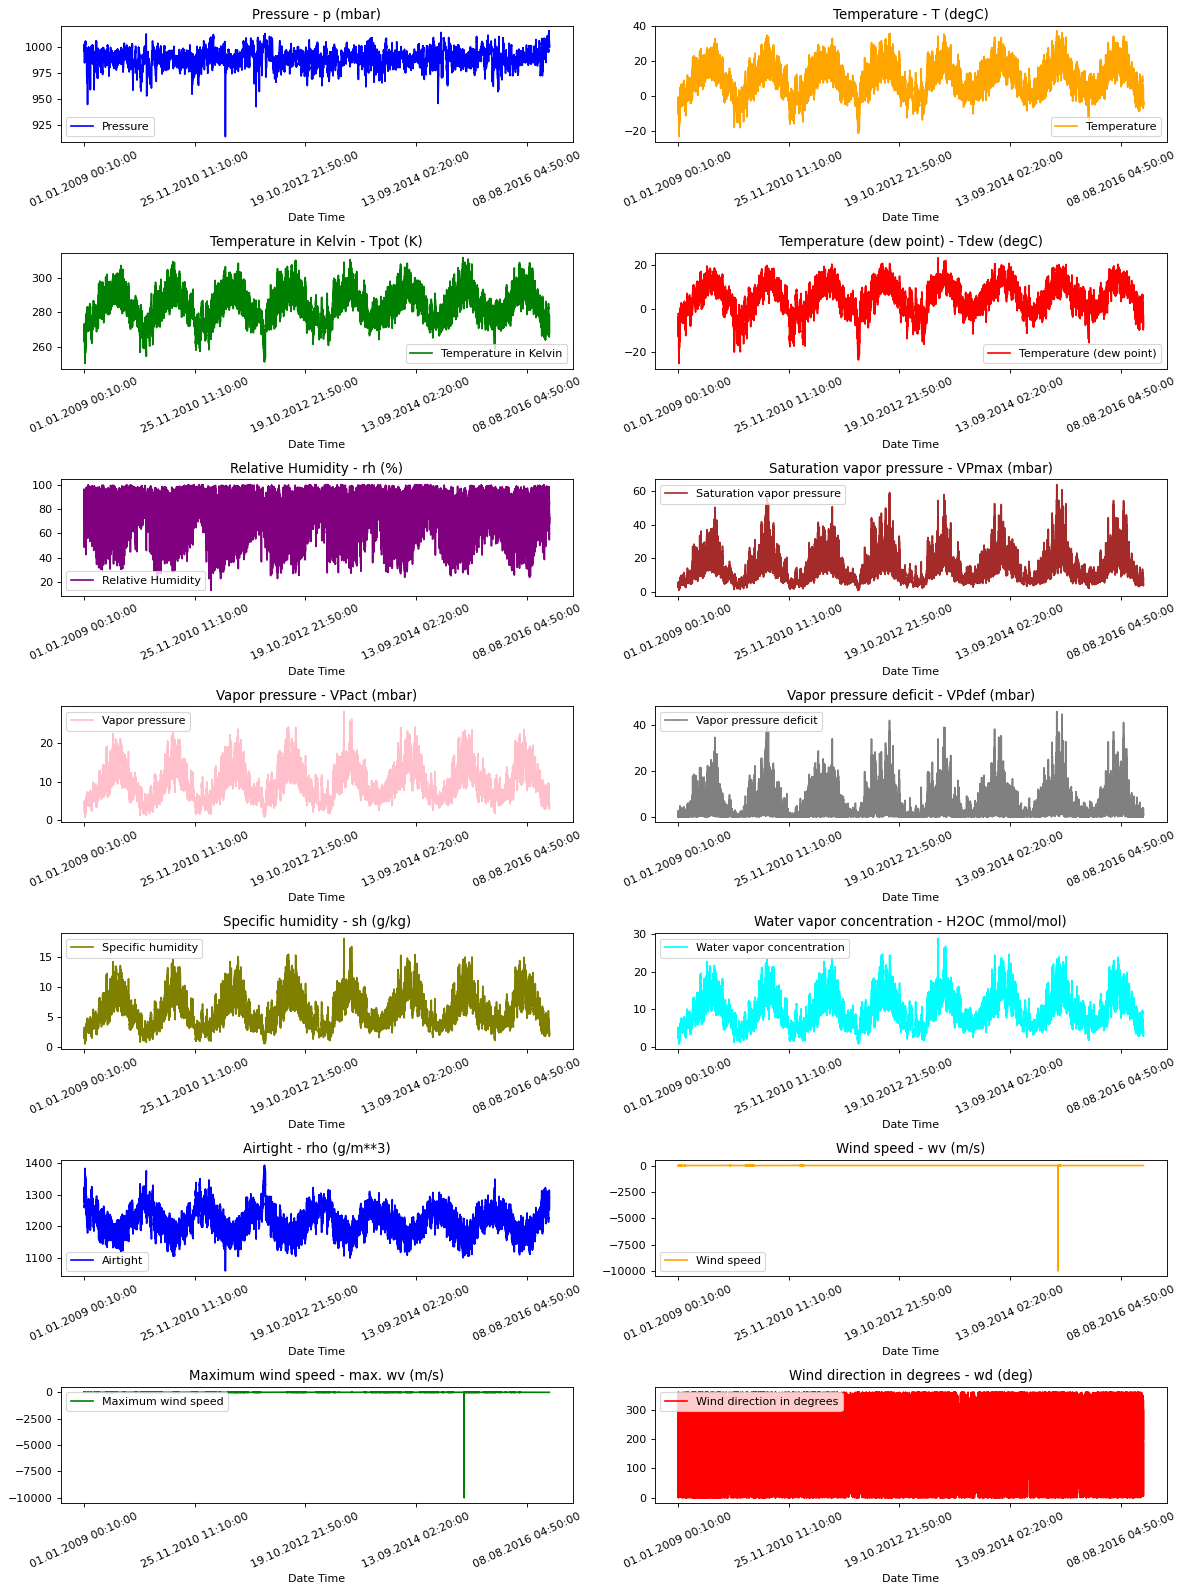

In [327]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

## Preparação (transformação, pré-processamento) dos dados

Por simplificidade, nessa demonstração iremos considerar **predições/observações por hora**. Sendo assim, vamos realizar uma subamostragem dos dados originais para converter a frequência de observações de 10 min para 1 hora.

In [328]:
print(df.shape)

# slice [start:stop:step], starting from index 5, take every 6th record.
df = df[5::6]

print(df.shape)

(420551, 15)
(70091, 15)


In [329]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Podemos visualizar novamente os dados resultantes da subamostragem. Ao fazer isso, vamos perceber que não ocorreu nenhuma mudança drástica nas distribuições dos valores por conta da subamostragem realizada.

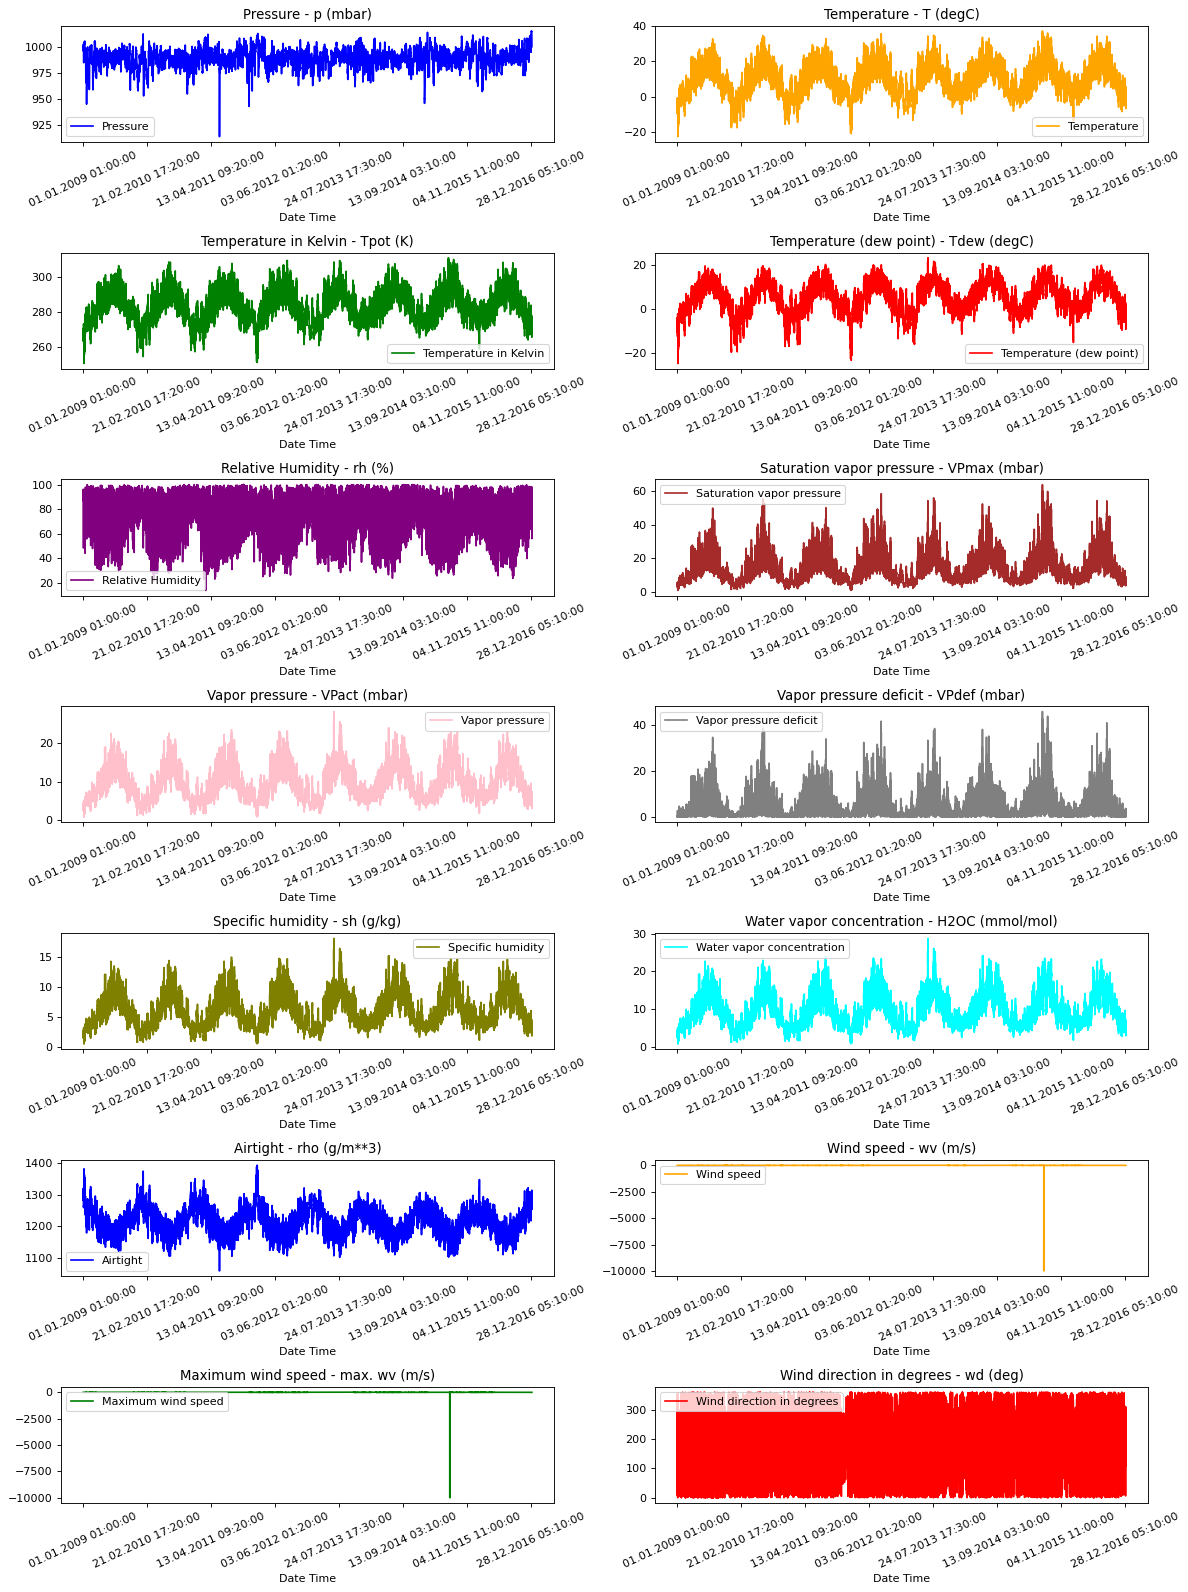

In [330]:
show_raw_visualization(df)

Esse conjunto de dados possui uma variávei denominada `Date Time` que corresponde à marcação de tempo relativa a cada observação. Em uma aplicação real, esse tipo de variável pode ser usado como preditor, após algumas ações de pré-processamento (e.g., tratamento de **variáveis cíclicas**). Por simplicidade, nessa demonstração, não vamos usar essa variável como preditor.

In [331]:
date_time = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
date_time.head()

5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]

Nessa demonstração, vamos construir um modelo de previsão considerando que a variável alvo seja **temperatura** (medida em graus Celsius). A célula de código abaixo exibe um sumário estatístico dessa variável.

In [332]:
df_multi = df[['T (degC)']]
df_multi.describe()

,T (degC)
count,70091.000000
mean,9.450482
std,8.423384
min,-22.760000
25%,3.350000
50%,9.410000
75%,15.480000
max,37.280000


O histograma dessa variável também parece indicar que não há valores anômalos e que ela segue aproximadamente uma distribuição normal.

array([[<Axes: title={'center': 'T (degC)'}>]], dtype=object)

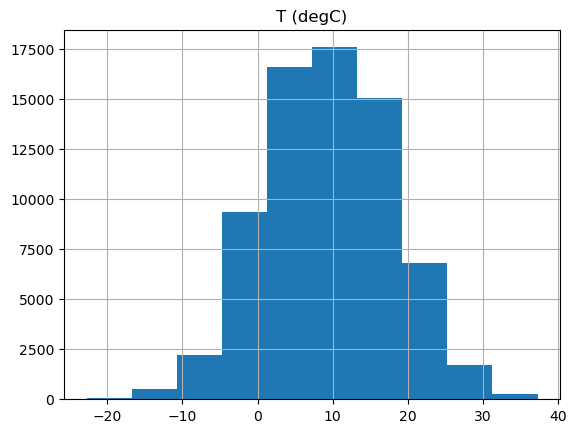

In [333]:
df_multi.hist()

Vamos agora separar os exemplos originalmente disponíveis em três conjuntos disjuntos:

- **conjunto de treino**: usado para ajustar os parâmetros do modelo de previsão
- **conjunto de validação**: usado para monitorar o processo de treinamento. Também usado para sintonizar os hiperparâmetros do modelo (não estamos fazendo isso nessa demonstração).
- **conjunto de teste**: após o modelo ter sido ajustado, esse conjunto é usado para obter uma estimativa realista do seu desempenho preditivo. 

Em uma aplicação real, o ideal seria utilizar integralmente todos os exemplos disponíveis. Entretanto, para fins de simplicidade nessa demonstração, vamos usar apenas **uma amostra contígua** da série temporal e, dentro dessa amostra, separar os dados em treino/validação/teste.


In [334]:
len(df_multi)

70091

In [335]:
df_multi.shape

(70091, 1)

Agora, vamos dividir a série original em conjuntos de treino, validação e teste. No contexto de séries temporais, a separação dos conjuntos de treino, validação e teste **deve preservar a ordem temporal dos dados para evitar [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)) (vazamento de informações do futuro para o passado)**. Diferentemente de problemas de aprendizado supervisionado convencional, onde os dados podem ser embaralhados, em séries temporais devemos considerar a dependência temporal entre as observações.

In [336]:
sample_size = 2500
sample_df = df_multi.iloc[-sample_size:]

n = len(sample_df)
train_end = int(n * 0.7)
val_end = int(n * 0.9)

train_set = sample_df.iloc[:train_end]
val_set = sample_df.iloc[train_end:val_end]
test_set = sample_df.iloc[val_end:]

print(f'Tamanho da amostra: {n}')
print(f'Proporção de treino: {len(train_set)/n:.2%}')
print(f'Proporção de validação: {len(val_set)/n:.2%}')
print(f'Proporção de teste: {len(test_set)/n:.2%}')


Tamanho da amostra: 2500
Proporção de treino: 70.00%
Proporção de validação: 20.00%
Proporção de teste: 10.00%


In [337]:
print('Treino: {:d}'.format(train_set.shape[0]))
print('Validação: {:d}'.format(val_set.shape[0]))
print('Teste: {:d}'.format(test_set.shape[0]))

Treino: 1750
Validação: 500
Teste: 250


### Normalização (usando apenas treino)


In [338]:
target_col = 'T (degC)'
train_mean = train_set.mean()
train_std = train_set.std()

train_set_norm = (train_set - train_mean) / train_std
val_set_norm = (val_set - train_mean) / train_std
test_set_norm = (test_set - train_mean) / train_std

print('Média/Desvio (treino):')
print(train_mean)
print(train_std)


Média/Desvio (treino):
T (degC)    7.985349
dtype: float64
T (degC)    5.569118
dtype: float64


### Janelamento (*data windowing*)

Agora devemos processar os conjuntos de dados para formar os exemplos de treinamento. Aqui, vamos enquadrar o problema de previsão em séries temporais como um problema de *aprendizado supervisionado* para construir um modelo auto-regressivo. Para isso, vamos usar a técnica de [janelas deslizantes](https://datascience.stackexchange.com/questions/29173/time-series-forecasting-sliding-window-method) para construir os exemplos. 

A função `window_generator` definida abaixo implementa uma variante da técnica de janelas deslizantes. Essa função recebe dois argumentos:

- `sequence`: a série temporal a ser processada para obtenção dos exemplos de treinamento;
- `n_steps`: a quantidade de observações prévias a serem usadas como preditores.

In [339]:
def window_generator_uni(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

Para um melhor entendimento da função acima, considere a série temporal fictícia a seguir:
$$
10,20,30,40,50,60,70,80,90
$$

Suponha que, após uma análise criteriosa, decidimos utilizar os valores de temperaturas observados nas **três** últimas horas para prever a temperatura na hora seguinte. Para isso, podemos chamar a função `window_generator` com o valor do argumento `n_steps` igual a 3. Ao fazermos isso, a função retorna duas matrizes. A primeira é a denominada **matriz de dados** e contém os valores usados como preditores. A segunda é conhecida no aprendizado supervisionado como **vetor de resposta** é contém o sinal de aprendizado (i.e., o valor correto que o modelo de previsão deveria produzir).

In [340]:
n_steps = 3
seq = np.array([10,20,30,40,50,60,70,80,90])
seq_train_x, seq_train_y = window_generator_uni(seq, n_steps)

df_toy = pd.DataFrame(seq_train_x)
df_toy.columns =['t_3', 't_2', 't_1']
df_toy['target'] = seq_train_y.tolist()

df_toy.head()

,t_3,t_2,t_1,target
0,10,20,30,40
1,20,30,40,50
2,30,40,50,60
3,40,50,60,70
4,50,60,70,80


É possível também aplicar a técnica de janelas deslizantes sobre séries temporais multi-vairadas, conforme o exemplo abaixo.

Repare que as versões da função `window_generator` implementadas acima correspondem a uma variante particular da técnica de janela deslizantes. Em particular, essa variante gera o conjunto de dados de treinamento de acordo com a abordagem [single step prediction](https://machinelearningmastery.com/multi-step-time-series-forecasting/), o que corresponde a definir $q_{out}=1$.

A features criadas usando valores de observações em diferentes passos de tempo anteriores são chamadas de *lag features*.
  
> Lagged features are a feature engineering technique used to capture the temporal dependencies and patterns in time series data. A lagged feature is created by taking the value of a variable at a previous time point and including it as a feature in the model at the current time point. This is done by shifting the time series data by a certain number of time steps, which is referred to as the lag or time lag.

### Divisão: treino, validação, teste

Vamos agora aplicar a técnica de janelas deslizantes aos dados de temperatura contidos em nosso conjunto de dados. Vamos considerar que a quantidade de observações prévias usadas para realizar a previsão é igual a 3 (i.e., $q_{in}=3)$.

In [341]:
n_steps = 3 # q_in
train_x, train_y = window_generator_uni(train_set_norm.values, n_steps)
valid_x, valid_y = window_generator_uni(val_set_norm.values, n_steps)
test_x, test_y = window_generator_uni(test_set_norm.values, n_steps)


In [342]:
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)

(1747, 3, 1)
(497, 3, 1)
(247, 3, 1)


In [343]:
train_x

array([[[ 3.08929548],
        [ 2.79301877],
        [ 2.6870774 ]],

       [[ 2.79301877],
        [ 2.6870774 ],
        [ 2.49674206]],

       [[ 2.6870774 ],
        [ 2.49674206],
        [ 2.30101987]],

       ...,

       [[-1.1375856 ],
        [-0.65456478],
        [-0.76230177]],

       [[-0.65456478],
        [-0.76230177],
        [-0.79821409]],

       [[-0.76230177],
        [-0.79821409],
        [-0.81078341]]])

Agora transformamos as variáveis em tensores PyTorch para uso no ajuste e validação do modelo. Veja o bloco de código abaixo.

In [344]:
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

valid_x = torch.from_numpy(valid_x)
valid_y = torch.from_numpy(valid_y)

test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

### Reposicionamento de dimensões

A classe `nn.Conv1D` do PyTorch (que será usada para definir a rede neural a ser treinada) espera que cada tensor usado no treinamento tenha a forma `[batch, in_channels, time]`, onde 
- `batch`: tamanho selecionado para cada lote;
- `in_channels`: quantidade de features (canais) medidas em cada passo de tempo;
- `time`: comprimento da sequência (janela temporal).

Nesse formato, a dimensão de features (`in_channels`) deve ficar na posição central. Assim, se os dados estiverem originalmente em `[batch, time, in_channels]`, usamos `permute` para reordenar as dimensões: `x.permute(0, 2, 1)` troca as dimensões 1 e 2, resultando em `[batch, in_channels, time]`.

In [345]:
train_x = torch.permute(train_x, (0, 2, 1))
valid_x = torch.permute(valid_x, (0, 2, 1))
test_x = torch.permute(test_x, (0, 2, 1))

print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)

torch.Size([1747, 1, 3])
torch.Size([497, 1, 3])
torch.Size([247, 1, 3])


Vamos agora criar os objetos `TensorDataset` e `Dataloader` para os conjuntos de treino, validação e teste.

In [346]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(train_x, train_y)
valid_ds = TensorDataset(valid_x, valid_y)
test_ds = TensorDataset(test_x, test_y)

BATCH_SIZE = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
val_dl = torch.utils.data.DataLoader(valid_ds, batch_size = BATCH_SIZE, shuffle = False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False)

In [347]:
# %load device_dataloader.py
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

O código acima não faz nenhuma transformação especial. Em vez disso, ela formata os dados para serem usados pelo PyTorch durante o processo de treinamento do modelo. 

Como exemplo, considere a célula de código abaixo, que imprime os cinco primeiros exemplos contidos no conjunto de dados de treinamento encapsulado pelo objeto `TensorDataset`.

In [348]:
train_ds = TensorDataset(train_x, train_y)
train_ds[0:5]

(tensor([[[3.0893, 2.7930, 2.6871]],
 
         [[2.7930, 2.6871, 2.4967]],
 
         [[2.6871, 2.4967, 2.3010]],
 
         [[2.4967, 2.3010, 2.1017]],
 
         [[2.3010, 2.1017, 1.8862]]], dtype=torch.float64),
 tensor([[2.4967],
         [2.3010],
         [2.1017],
         [1.8862],
         [1.6510]], dtype=torch.float64))

O hiperparâmetro `BATCH_SIZE` (usado para configurar o objeto `DataLoader`) define a quantidade de exemplos a ser usada em cada interação de ajuste dos parâmetros do modelo.

Para fins de inspeção, o bloco de código a seguir imprime os exemplos componentes do primeiro lote de de treinamento.

In [349]:
for xb, yb in train_dl:
    print(xb.shape)
    print(yb.shape)
    print(xb)
    print(yb)
    break

torch.Size([32, 1, 3])
torch.Size([32, 1])
tensor([[[-1.3225, -1.3926, -1.4392]],

        [[ 1.3062,  1.1033,  1.1195]],

        [[-1.3279, -1.2615, -1.2328]],

        [[-0.1410, -0.4642, -0.4930]],

        [[-1.0622, -1.0191, -0.9868]],

        [[ 0.7550,  0.5503,  0.2881]],

        [[ 0.5503,  0.2881,  0.1499]],

        [[ 1.6510,  1.4427,  1.3098]],

        [[-0.2613, -0.2362, -0.2667]],

        [[ 0.6311,  0.6957,  0.9238]],

        [[ 1.6438,  1.6833,  1.5882]],

        [[ 0.8520,  0.8053,  0.7927]],

        [[ 0.8717,  0.5988,  0.4569]],

        [[ 0.3725,  0.3007,  0.2684]],

        [[ 0.0188, -0.1374, -0.2972]],

        [[-0.9293, -0.9903, -0.9814]],

        [[ 0.3923,  0.4192,  0.3169]],

        [[ 0.6616,  0.7029,  0.6796]],

        [[ 0.4390,  0.4982,  0.5252]],

        [[ 0.4839,  0.6904,  0.6778]],

        [[-1.3531, -1.3459, -1.3423]],

        [[-0.7874, -0.7874, -0.5774]],

        [[ 0.6275,  0.6383,  0.6006]],

        [[ 0.6275,  0.5700,  0.4228]]

## Definição da rede neural

Agora vamos definir a classe que corresponde à rede neural a ser treinada. No PyTorch, é uma boa prática implementar essa classe como uma subclasse de [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

In [350]:
# %load net.py
class Net(nn.Module):
    def __init__(self, in_channels, input_length):
        super(Net, self).__init__()
        self.conv1d = nn.Conv1d(in_channels, 64, kernel_size=3)
        self.relu = nn.ReLU()
        
        # Compute the output length after the Conv1d layer
        # Assuming no padding and stride of 1
        conv_out_length = input_length - 3 + 1  # Length after applying kernel_size=3
        self.fc1 = nn.Linear(64 * conv_out_length, 50)  # Adjusted the input size for fc1
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(x.shape[0], -1)  # Flattening the output
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Repare que a classe [Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) é usada na definição da arquitetura de rede neural acima. Em particular o parâmetro `in_channels` usado na instanciação desta camada corresponde à quantidade de features observadas a cada passo de tempo. Visto que a cada passo de tempo consideramos apenas um valor de temperatura, definimos `in_channels = 1`.

O bloco de código a seguir cria o modelo e move-o para o espaço de memória da GPU (se uma estiver disponível).

In [351]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Net(in_channels=1, input_length=3)
model = model.to(device=device, dtype=torch.float32)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

cpu


Podemos obter uma visão geral da arquitetura da rede neural montada apenas imprimindo a variável `model`.

In [352]:
print(model)

Net(
  (conv1d): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


Tente refletir sobre a razão de a primeira camada completamente conectada (fc1) ter dimensão de entrada igual a 128.

Apenas para fins de inspeção, o bloco de código a seguir imprime as dimensões do tensor correspondente ao primeiro lote de treinamento.

In [353]:
for xb, yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 1, 3])
torch.Size([32, 1])


Também para fins de inspeção e comparação posterior, vamos computar o erro médio cometido pelo modelo (ainda não treinado!) sobre o conjunto de teste.

In [354]:
# test_losses = []
# for xb, yb in test_dl:
#   output = model(xb.float())
#   # calculate the loss
#   loss = criterion(output, yb.float())
#   # record validation loss
#   test_losses.append(loss.item())
# test_loss = np.average(test_losses)
# print(test_loss)

## Treinamento do modelo (fit)

Nesse ponto, está tudo pronto para iniciar o treinamento do modelo. A função `fit` definida abaixo realiza esse treinamento.

In [355]:
# %load fit.py
def fit(epochs, lr, model, train_dl, val_dl, criterion, optimizer):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    optimizer = optimizer(model.parameters(), lr)
    for epoch in range(epochs):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for data, target in train_dl:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())

            # calculate the loss
            loss = criterion(output, target.float())
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in val_dl:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.float())
            # calculate the loss
            loss = criterion(output, target.float())
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
  
    return  model, avg_train_losses, avg_valid_losses

Uma estratégia simples que pode ser adotada durante o treinamento é definir uma quantidade fixa de épocas de treinamento.

In [356]:
n_epochs = 300
lr = 1e-5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam

model, train_loss, valid_loss = fit(n_epochs, 
                                    lr, 
                                    model, 
                                    train_dl, 
                                    val_dl, 
                                    criterion, 
                                    optimizer)

[  0/300] train_loss: 1.09067 valid_loss: 1.93831
[  1/300] train_loss: 1.06751 valid_loss: 1.88206
[  2/300] train_loss: 1.03610 valid_loss: 1.82902
[  3/300] train_loss: 1.00058 valid_loss: 1.77612
[  4/300] train_loss: 0.97061 valid_loss: 1.72250
[  5/300] train_loss: 0.94326 valid_loss: 1.67058
[  6/300] train_loss: 0.91549 valid_loss: 1.61301
[  7/300] train_loss: 0.88345 valid_loss: 1.55356
[  8/300] train_loss: 0.85626 valid_loss: 1.49852
[  9/300] train_loss: 0.82815 valid_loss: 1.44202
[ 10/300] train_loss: 0.79913 valid_loss: 1.38778
[ 11/300] train_loss: 0.77243 valid_loss: 1.33576
[ 12/300] train_loss: 0.74745 valid_loss: 1.28379
[ 13/300] train_loss: 0.71718 valid_loss: 1.23081
[ 14/300] train_loss: 0.69416 valid_loss: 1.17782
[ 15/300] train_loss: 0.66504 valid_loss: 1.12756
[ 16/300] train_loss: 0.63520 valid_loss: 1.07713
[ 17/300] train_loss: 0.61030 valid_loss: 1.02768
[ 18/300] train_loss: 0.58829 valid_loss: 0.97940
[ 19/300] train_loss: 0.56308 valid_loss: 0.92724


Porque os erros de treino e de validação foram registrados durante o treinamento, podemos desenhar um gráfico para analisar visualmente a evolução desses valores. Isso é feito na célula de código abaixo.

O gráfico gerado apresenta duas curvas, uma para o erro medido no conjunto de treinamento e outra para o erro medido no conjunto de validação. Essas chamadas **curvas de aprendizado** (*learning curves*) são muito úteis para realizar disgnósticos durante o treinamento. 


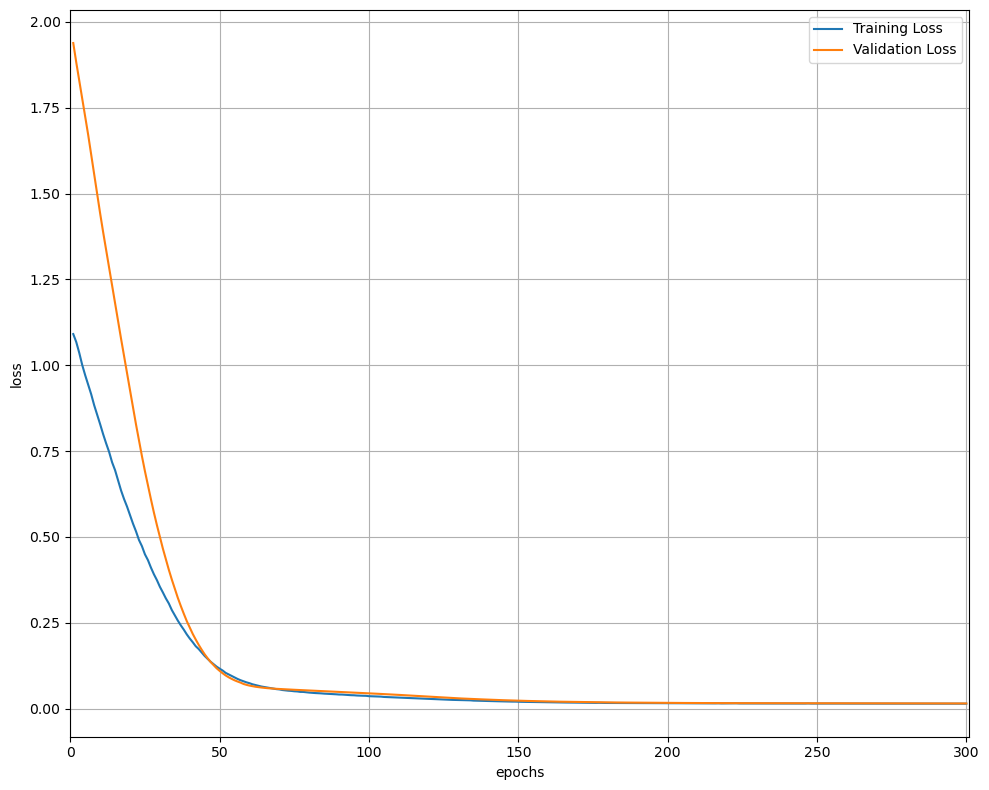

In [357]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

A análise do gráfico acima parece indicar que o treinamento aconteceu de forma satisfatória. Para confirmar isso, devemos usar o modelo recém-ajustado para predizer os valores de temperatura sobre o conjunto de dados de teste.

In [358]:
test_losses = []
for xb, yb in test_dl:
  output = model(xb.float())
  # calculate the loss
  loss = criterion(output, yb.float())
  # record validation loss
  test_losses.append(loss.item())
test_loss = np.average(test_losses)
print(test_loss)

0.013110694533679634


O resultado produzido pelo bloco de código acima é o erro médio (computado usando a métrica MSE) do modelo sobre os exemplos de teste. Compare esse valor (obtido após o treinamento) com o que computamos antes do treinamento. O que você percebe de diferente?

## Predição (inferência)

Uma vez que o modelo está treinado (ajustado), podemos usá-lo para realizar inferências. No código abaixo, apenas a título de exemplo, os 10 primeiros exemplos do conjunto de teste são passados ao modelo. 

Test MSE:  0.376394
Test RMSE: 0.613510
Test MAE:  0.407996


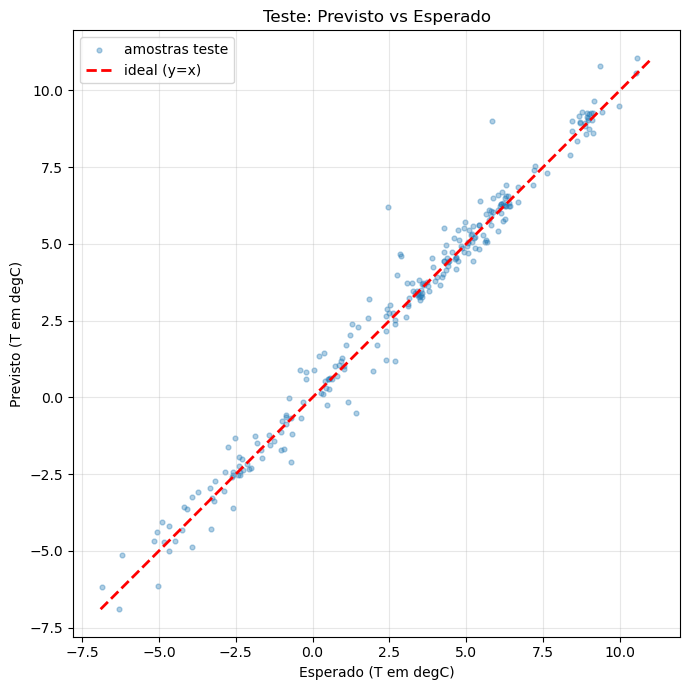

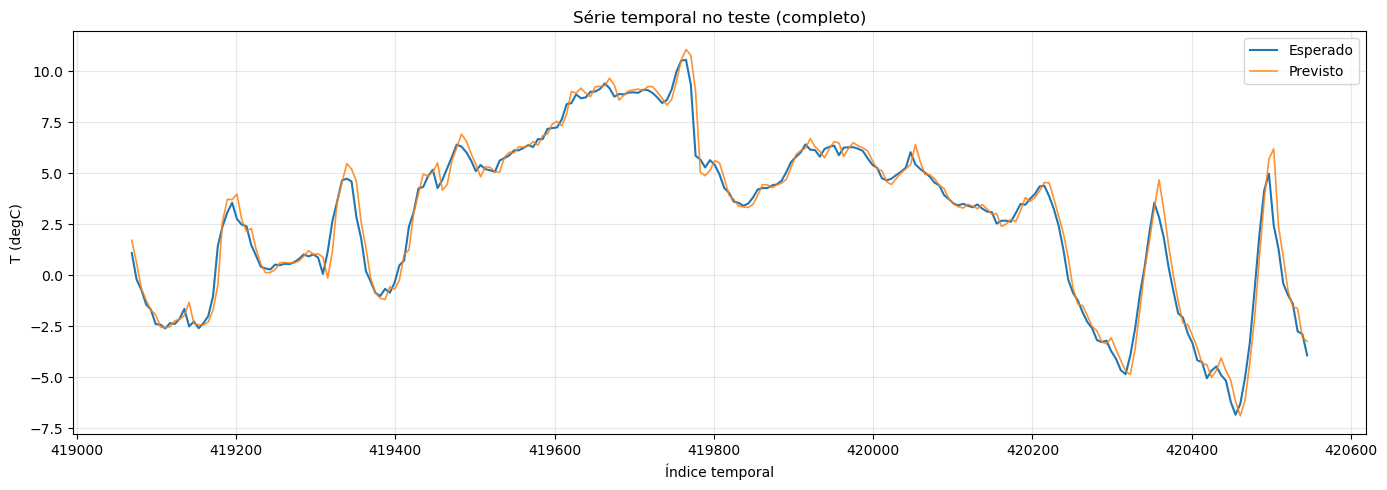

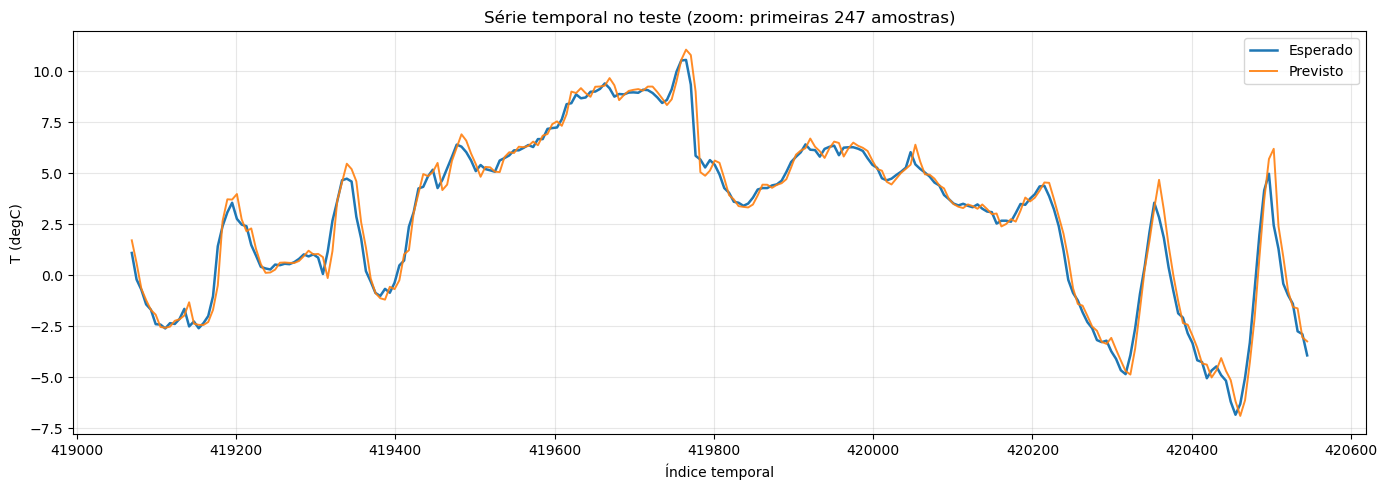

In [359]:
# Inferência no conjunto de teste
model.eval()
y_true_batches = []
y_pred_batches = []

with torch.no_grad():
    for xb, yb in test_dl:
        pred = model(xb.float())
        y_true_batches.append(yb.detach().cpu().numpy())
        y_pred_batches.append(pred.detach().cpu().numpy())

y_true_norm = np.concatenate(y_true_batches).reshape(-1)
y_pred_norm = np.concatenate(y_pred_batches).reshape(-1)

# Desnormalização para escala original
target_mean = train_mean[target_col]
target_std = train_std[target_col]
y_true = y_true_norm * target_std + target_mean
y_pred = y_pred_norm * target_std + target_mean

# Métricas de regressão no teste
mse_test = np.mean((y_true - y_pred) ** 2)
rmse_test = np.sqrt(mse_test)
mae_test = np.mean(np.abs(y_true - y_pred))

print(f'Test MSE:  {mse_test:.6f}')
print(f'Test RMSE: {rmse_test:.6f}')
print(f'Test MAE:  {mae_test:.6f}')

# Plot 1: previsto vs esperado
plt.figure(figsize=(7, 7))
plt.scatter(y_true, y_pred, alpha=0.35, s=12, label='amostras teste')
line_min = min(np.min(y_true), np.min(y_pred))
line_max = max(np.max(y_true), np.max(y_pred))
plt.plot([line_min, line_max], [line_min, line_max], 'r--', linewidth=2, label='ideal (y=x)')
plt.xlabel('Esperado (T em degC)')
plt.ylabel('Previsto (T em degC)')
plt.title('Teste: Previsto vs Esperado')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: séries temporais esperado vs previsto
test_time_index = test_set.index[n_steps:n_steps + len(y_true)]

plt.figure(figsize=(14, 5))
plt.plot(test_time_index, y_true, label='Esperado', linewidth=1.5)
plt.plot(test_time_index, y_pred, label='Previsto', linewidth=1.2, alpha=0.85)
plt.title('Série temporal no teste (completo)')
plt.xlabel('Índice temporal')
plt.ylabel('T (degC)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

zoom_n = min(300, len(y_true))
plt.figure(figsize=(14, 5))
plt.plot(test_time_index[:zoom_n], y_true[:zoom_n], label='Esperado', linewidth=1.8)
plt.plot(test_time_index[:zoom_n], y_pred[:zoom_n], label='Previsto', linewidth=1.4, alpha=0.9)
plt.title(f'Série temporal no teste (zoom: primeiras {zoom_n} amostras)')
plt.xlabel('Índice temporal')
plt.ylabel('T (degC)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Referências

- [How to perform a 1D convolution in python ?](https://moonbooks.org/Articles/How-to-perform-a-1D-convolution-in-python-/#references)

- [4 Strategies for Multi-Step Time Series Forecasting](https://machinelearningmastery.com/multi-step-time-series-forecasting/)

- [Time Series One Step Ahead vs N-Step Ahead](https://stats.stackexchange.com/questions/342392/time-series-one-step-ahead-vs-n-step-ahead)

- [How to Develop Convolutional Neural Network Models for Time Series Forecasting](https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting)

- [1D convolution for neural networks](https://www.youtube.com/watch?v=XBF9iqt0CnA)

- [1D convolutional neural networks and applications: A survey](https://www.sciencedirect.com/science/article/pii/S0888327020307846)



# Miscelânea

In [360]:
import numpy as np
np.random.seed(42)
multivariate_ts = np.random.uniform(0, 20, (10,3))
multivariate_ts

array([[ 7.49080238, 19.01428613, 14.63987884],
       [11.97316968,  3.12037281,  3.11989041],
       [ 1.16167224, 17.32352292, 12.02230023],
       [14.16145156,  0.41168989, 19.39819704],
       [16.64885282,  4.24678221,  3.63649934],
       [ 3.6680902 ,  6.08484486, 10.49512863],
       [ 8.63890037,  5.8245828 , 12.23705789],
       [ 2.78987721,  5.84289297,  7.32723687],
       [ 9.12139968, 15.70351923,  3.99347564],
       [10.28468877, 11.84829138,  0.92900825]])

In [361]:
multivariate_ts[2:10:1, 2]

array([12.02230023, 19.39819704,  3.63649934, 10.49512863, 12.23705789,
        7.32723687,  3.99347564,  0.92900825])

In [362]:
multivariate_ts[np.array([1,2,3,4])]

array([[11.97316968,  3.12037281,  3.11989041],
       [ 1.16167224, 17.32352292, 12.02230023],
       [14.16145156,  0.41168989, 19.39819704],
       [16.64885282,  4.24678221,  3.63649934]])

In [363]:
multivariate_ts.shape[1]

3

In [364]:
I = np.array([[0,1,2,3], [1,2,3,4], [2,3,4,5]])
multivariate_ts[I]

array([[[ 7.49080238, 19.01428613, 14.63987884],
        [11.97316968,  3.12037281,  3.11989041],
        [ 1.16167224, 17.32352292, 12.02230023],
        [14.16145156,  0.41168989, 19.39819704]],

       [[11.97316968,  3.12037281,  3.11989041],
        [ 1.16167224, 17.32352292, 12.02230023],
        [14.16145156,  0.41168989, 19.39819704],
        [16.64885282,  4.24678221,  3.63649934]],

       [[ 1.16167224, 17.32352292, 12.02230023],
        [14.16145156,  0.41168989, 19.39819704],
        [16.64885282,  4.24678221,  3.63649934],
        [ 3.6680902 ,  6.08484486, 10.49512863]]])

In [365]:
import numpy as np
def apply_windowing(X, 
                    initial_time_step, 
                    max_time_step, 
                    window_size, 
                    idx_target,
                    only_y_not_nan = False,
                    only_y_gt_zero = False,
                    only_X_not_nan = False):

  assert idx_target >= 0 and idx_target < X.shape[1]
  assert initial_time_step >= 0
  assert max_time_step >= initial_time_step

  start = initial_time_step
    
  sub_windows = (
        start +
        # expand_dims converts a 1D array to 2D array.
        np.expand_dims(np.arange(window_size), 0) +
        np.expand_dims(np.arange(max_time_step + 1), 0).T
  )

  X_temp, y_temp = X[sub_windows], X[window_size:(max_time_step+window_size+1):1, idx_target]

  if only_y_not_nan and only_y_gt_zero and only_X_not_nan:
    y_train_not_nan_idx = np.where(~np.isnan(y_temp))[0]
    y_train_gt_zero_idx = np.where(y_temp>0)[0]
    x_train_is_nan_idx = np.unique(np.where(np.isnan(X_temp)))
    idxs = np.intersect1d(y_train_not_nan_idx, y_train_gt_zero_idx)
    idxs = np.setdiff1d(idxs, x_train_is_nan_idx)
    X_temp, y_temp = X_temp[idxs], y_temp[idxs]

  return X_temp, y_temp

In [366]:
multivariate_ts

array([[ 7.49080238, 19.01428613, 14.63987884],
       [11.97316968,  3.12037281,  3.11989041],
       [ 1.16167224, 17.32352292, 12.02230023],
       [14.16145156,  0.41168989, 19.39819704],
       [16.64885282,  4.24678221,  3.63649934],
       [ 3.6680902 ,  6.08484486, 10.49512863],
       [ 8.63890037,  5.8245828 , 12.23705789],
       [ 2.78987721,  5.84289297,  7.32723687],
       [ 9.12139968, 15.70351923,  3.99347564],
       [10.28468877, 11.84829138,  0.92900825]])

In [367]:
multivariate_ts[0,0] = np.NAN
multivariate_ts[1,0] = np.NAN
multivariate_ts[4,0] = np.NAN
multivariate_ts[1,1] = 0
multivariate_ts[2,1] = 0
multivariate_ts[6,1] = 0
multivariate_ts[7,2] = np.NAN

In [368]:
multivariate_ts

array([[        nan, 19.01428613, 14.63987884],
       [        nan,  0.        ,  3.11989041],
       [ 1.16167224,  0.        , 12.02230023],
       [14.16145156,  0.41168989, 19.39819704],
       [        nan,  4.24678221,  3.63649934],
       [ 3.6680902 ,  6.08484486, 10.49512863],
       [ 8.63890037,  0.        , 12.23705789],
       [ 2.78987721,  5.84289297,         nan],
       [ 9.12139968, 15.70351923,  3.99347564],
       [10.28468877, 11.84829138,  0.92900825]])

In [369]:
WS = 2 # size of window to use
IDX_TARGET = 1 # index position of the target variable
X, y = apply_windowing(multivariate_ts, 
                                  initial_time_step=0, 
                                  max_time_step=len(multivariate_ts)-WS-1, 
                                  window_size = WS, 
                                  idx_target = IDX_TARGET,
                                  only_y_not_nan = False,
                                  only_y_gt_zero = False,
                                  only_X_not_nan = False)

In [370]:
X

array([[[        nan, 19.01428613, 14.63987884],
        [        nan,  0.        ,  3.11989041]],

       [[        nan,  0.        ,  3.11989041],
        [ 1.16167224,  0.        , 12.02230023]],

       [[ 1.16167224,  0.        , 12.02230023],
        [14.16145156,  0.41168989, 19.39819704]],

       [[14.16145156,  0.41168989, 19.39819704],
        [        nan,  4.24678221,  3.63649934]],

       [[        nan,  4.24678221,  3.63649934],
        [ 3.6680902 ,  6.08484486, 10.49512863]],

       [[ 3.6680902 ,  6.08484486, 10.49512863],
        [ 8.63890037,  0.        , 12.23705789]],

       [[ 8.63890037,  0.        , 12.23705789],
        [ 2.78987721,  5.84289297,         nan]],

       [[ 2.78987721,  5.84289297,         nan],
        [ 9.12139968, 15.70351923,  3.99347564]]])

In [371]:
y

array([ 0.        ,  0.41168989,  4.24678221,  6.08484486,  0.        ,
        5.84289297, 15.70351923, 11.84829138])

In [372]:
WS = 2 # size of window to use
IDX_TARGET = 1 # index position of the target variable
X, y = apply_windowing(multivariate_ts, 
                                  initial_time_step=0, 
                                  max_time_step=len(multivariate_ts)-WS-1, 
                                  window_size = WS, 
                                  idx_target = IDX_TARGET,
                                  only_y_not_nan = True,
                                  only_y_gt_zero = True,
                                  only_X_not_nan = True)

In [373]:
X

array([[[ 3.6680902 ,  6.08484486, 10.49512863],
        [ 8.63890037,  0.        , 12.23705789]]])

In [374]:
y

array([5.84289297])

In [375]:
X.shape

(1, 2, 3)